## Imports

In [1]:
from crabnet.crabnet_ import get_data
from crabnet.data.materials_data import elasticity
from crabnet.crabnet_ import CrabNet

/workspaces/mat2vec_codespace/.venv/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data

In [2]:
train_df, val_df = get_data(elasticity, "train.csv", dummy=True)

In [3]:
#今回取得したこのテストデータの内容を見る
display(train_df)

,formula,index,target
55,AcOF,"(4945,)",108.0
88,Ag3Hg,"(9906,)",75.0
26,AcAg2Sn,"(1581,)",61.0
42,AcH3,"(5473,)",68.0
69,Ag2BiO3,"(4664,)",100.0
...,...,...,...
60,AcTe3,"(1705,)",48.0
71,Ag2F,"(306,)",74.0
14,Ac2SiAu,"(3552,)",62.0
92,Ag3Pd,"(5953,)",99.0


In [4]:
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80 entries, 55 to 51
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   formula  80 non-null     object 
 1   index    80 non-null     object 
 2   target   80 non-null     float64
dtypes: float64(1), object(2)
memory usage: 2.5+ KB
None


## CrabNet


Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cpu
Model size: 11987206 parameters



Generating EDM: 100%|██████████| 64/64 [00:00<00:00, 64188.30formulae/s]


loading data with up to 4 elements in the formula
training with batchsize 128 (2**7.000)


Generating EDM: 100%|██████████| 16/16 [00:00<00:00, 38679.46formulae/s]

loading data with up to 4 elements in the formula
stepping every 10 training passes, cycling lr every 10 epochs
checkin at 20 epochs to match lr scheduler


Epoch: 0/40 --- train mae: 20.1 val mae: 23.7


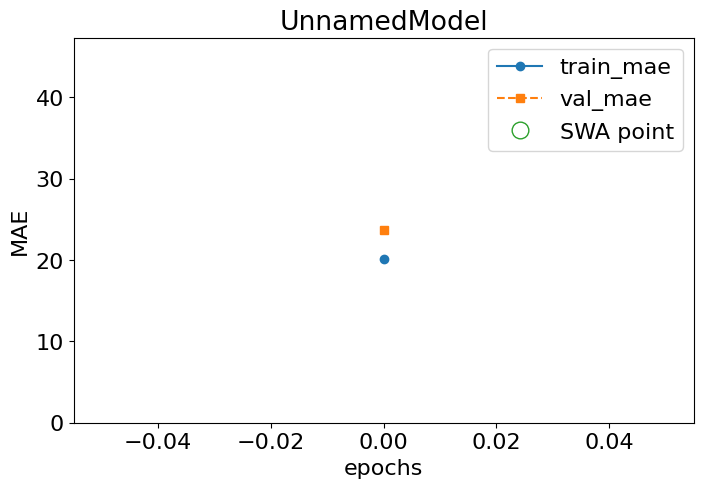

Epoch: 19/40 --- train mae: 14.8 val mae: 22.1


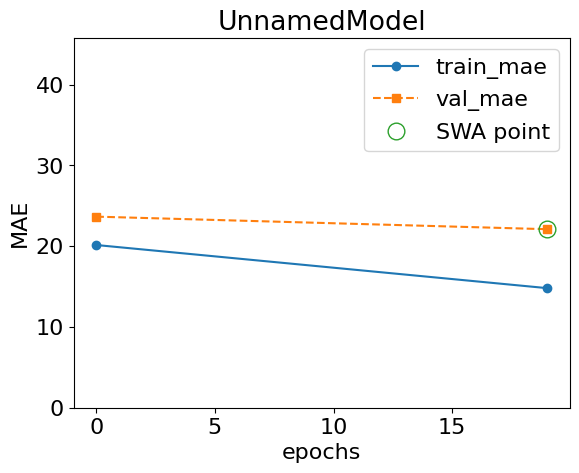

Epoch: 39/40 --- train mae: 13.8 val mae: 21.2


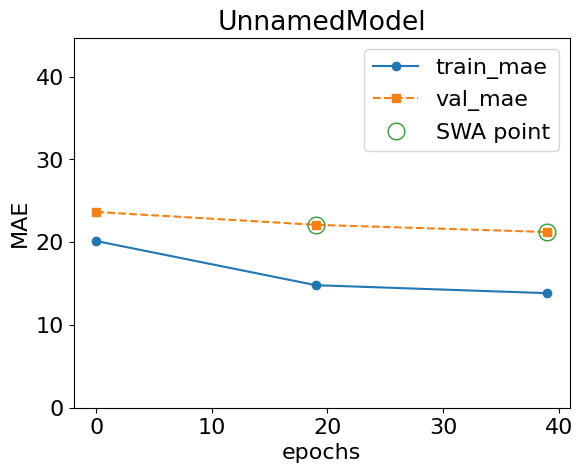

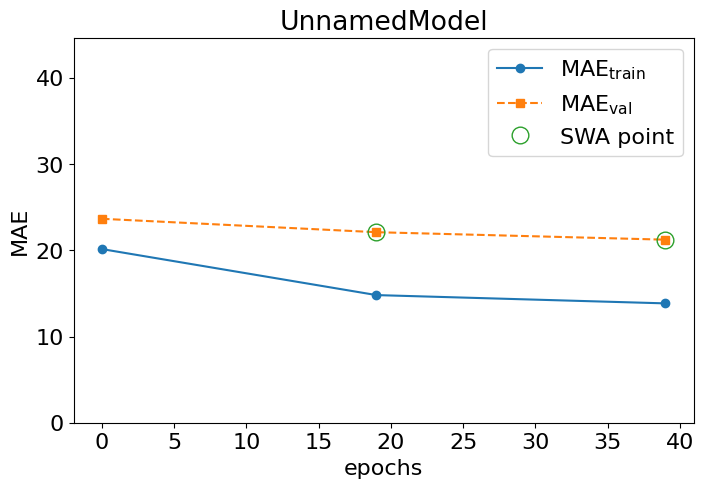

Saving network (UnnamedModel) to models/trained_models/UnnamedModel.pth


Generating EDM: 100%|██████████| 20/20 [00:00<00:00, 45003.26formulae/s]

loading data with up to 4 elements in the formula


In [5]:
%matplotlib inline
cb = CrabNet(mat_prop="elasticity", epochs=40)
cb.fit(train_df)
val_pred, val_sigma = cb.predict(val_df, return_uncertainty=True)

In [6]:
from os.path import join
from pathlib import Path
from typing import List

import numpy as np
import pandas as pd
from crabnet.utils.data import get_data
from crabnet.crabnet_ import CrabNet
import vickers_hardness.data as vh_data
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import (
    GroupKFold,
    GroupShuffleSplit,
    KFold,
    ShuffleSplit,
)
from vickers_hardness.utils.plotting import parity_with_err
from vickers_hardness.vickers_hardness_ import VickersHardness

In [7]:
X = get_data(vh_data, "hv_des.csv", groupby=False, split=False).rename(
    columns={"composition": "formula"}
)
prediction = get_data(vh_data, "hv_comp_load.csv", groupby=False, split=False)

In [8]:
display(X)

,formula,load,avg_ Atomic_Number,avg_ Atomic_Weight,avg_Period,avg_group,avg_families,avg_Mendeleev Number,avg_Atomic Radus,avg_ Covalent_Radius,...,min_Melting point (K),min_Boiling Point (K),min_Density (g/mL),min_specific heat (J/g K),min_heat of fusion (kJ/mol),min_heat of vaporization (kJ/mol),min_thermal conductivity (W/(m K)),min_heat atomization\n(kJ/mol),min_Cohesive energy,min_electron affinity (kJ/mol)
0,Ag0.05Gd0.048Pd0.902,0.49,46.914000,108.932250,5.048000,9.714000,3.952000,60.470000,1.429200,1.298840,...,1235.15,2485.15,7.90000,0.230,10.05000,250.5800,10.60000,284.0,2.95,13.2200
1,Ag0.05Y0.048Pd0.902,0.49,45.714000,105.651731,5.000000,9.714000,3.952000,59.750000,1.429200,1.299320,...,1235.15,2485.15,4.47000,0.235,11.30000,250.5800,17.20000,284.0,2.95,29.6000
2,Ag0.25Pb0.5Sb0.25Te,2.94,58.750000,144.303525,5.250000,14.750000,5.500000,84.000000,1.531250,1.390000,...,600.65,1262.95,6.24000,0.130,4.79900,52.5500,2.35000,196.0,2.03,34.4204
3,Al1.5Si1.5N2.5O1.5,0.98,10.000000,20.230930,2.428571,14.571429,6.357143,80.285714,0.864286,0.915000,...,54.75,77.35,0.00125,0.710,0.22259,2.7928,0.02598,249.0,2.62,-0.0700
4,Al1.67B22,2.00,5.564428,11.951887,2.070553,13.000000,5.929447,72.070553,0.878221,0.845399,...,933.15,2740.15,2.34000,0.900,10.79000,293.4000,27.00000,326.0,3.39,26.9890
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1057,ZrV2,0.98,28.666667,64.369000,4.333333,4.666667,4.000000,45.333333,1.416667,1.296667,...,2125.15,3653.15,6.11000,0.270,16.90000,0.4520,22.70000,514.0,5.31,41.8100
1058,ZrW2,0.98,62.666667,152.968000,5.666667,5.333333,4.000000,48.666667,1.416667,1.350000,...,2125.15,4650.15,6.51000,0.130,16.90000,58.2000,22.70000,609.0,6.25,41.8100
1059,OsB2,0.25,28.666667,70.617333,3.333333,11.333333,5.333333,67.000000,1.000000,0.966667,...,2352.15,2823.15,2.34000,0.130,31.80000,489.7000,27.00000,573.0,5.81,26.9890
1060,OsB2,0.49,28.666667,70.617333,3.333333,11.333333,5.333333,67.000000,1.000000,0.966667,...,2352.15,2823.15,2.34000,0.130,31.80000,489.7000,27.00000,573.0,5.81,26.9890


In [9]:
display(prediction)

,composition,hardness,load
0,Ag0.05Gd0.048Pd0.902,1.810,0.49
1,Ag0.05Y0.048Pd0.902,1.640,0.49
2,Ag0.25Pb0.5Sb0.25Te,0.578,2.94
3,Al1.5Si1.5N2.5O1.5,15.030,0.98
4,Al1.67B22,23.800,2.00
...,...,...,...
1057,ZrV2,3.600,0.98
1058,ZrW2,11.100,0.98
1059,OsB2,34.800,0.25
1060,OsB2,27.000,0.49


In [10]:
import torch
print(torch.__version__)

1.13.1+cu117



Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cpu
Model size: 11987206 parameters



Generating EDM: 100%|██████████| 620/620 [00:00<00:00, 193761.16formulae/s]


loading data with up to 5 elements in the formula
training with batchsize 128 (2**7.000)


Generating EDM: 100%|██████████| 156/156 [00:00<00:00, 136827.98formulae/s]

loading data with up to 5 elements in the formula
stepping every 50 training passes, cycling lr every 10 epochs
running for 300 epochs, unless early stopping occurs
checkin at 20 epochs to match lr scheduler


Epoch: 0/300 --- train mae: 11.3 val mae: 10.4


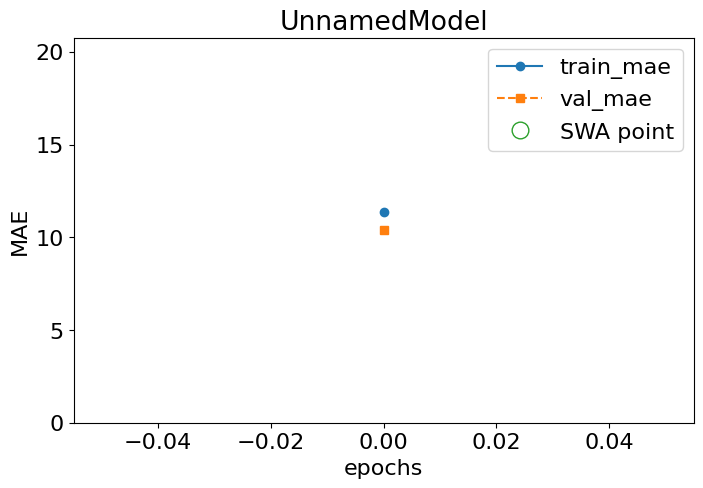

Epoch: 19/300 --- train mae: 3.76 val mae: 4.97


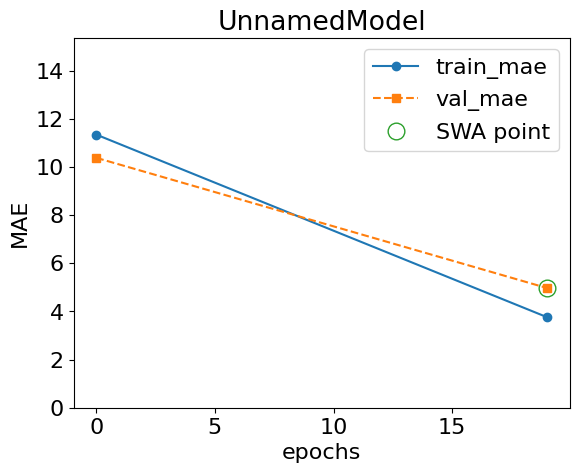

Epoch: 39/300 --- train mae: 3.42 val mae: 4.88


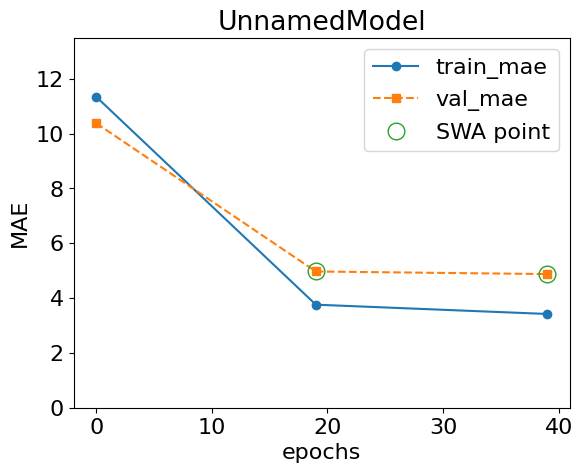

Epoch 59 failed to improve.
Discarded: 1/3 weight updates
Epoch: 59/300 --- train mae: 3.11 val mae: 5.08


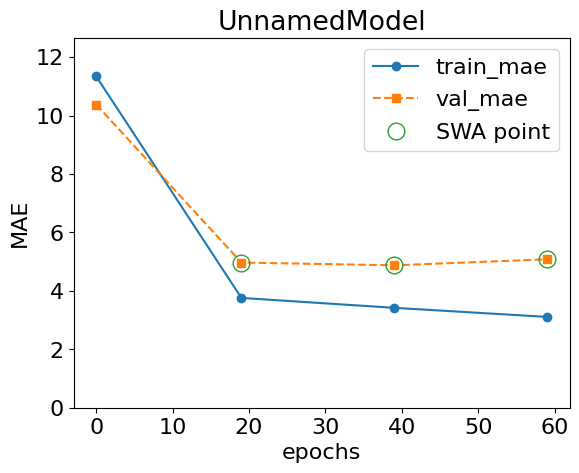

Epoch 79 failed to improve.
Discarded: 2/3 weight updates
Epoch: 79/300 --- train mae: 2.92 val mae: 4.99


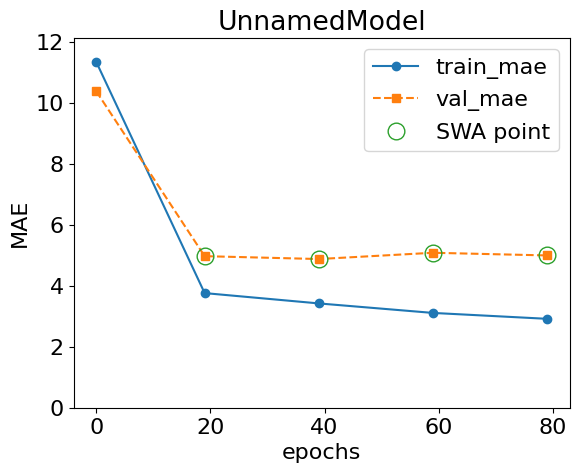

Epoch 99 failed to improve.
Discarded: 3/3 weight updates
Epoch: 99/300 --- train mae: 2.82 val mae: 5.03


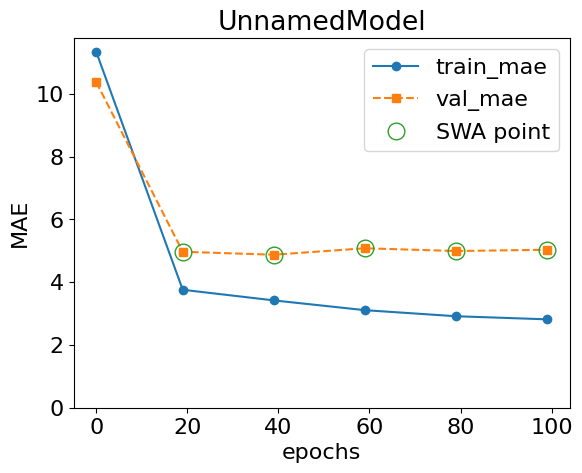

Discarded: 3/3weight updates, early-stopping now
Saving network (UnnamedModel) to models/trained_models/UnnamedModel.pth


Generating EDM: 100%|██████████| 195/195 [00:00<00:00, 120597.06formulae/s]

loading data with up to 5 elements in the formula


ValueError: too many values to unpack (expected 4)

In [11]:
#下記はCrabnetのExampleのコピーである
#これを説明していく
#vickersについては科学データのライブラリ
#今回調べているcrabnetと同様に組成式から硬度をXGboostなどを用いて評価することのできるライブラリであるらしい


"""Compare CrabNet `extend_features` with XGBoost for hardness dataset.

Dependency: `pip install vickers_hardness`, but then might run into issue with shapely.
See fix here: https://github.com/uncertainty-toolbox/uncertainty-toolbox/issues/59

"""


dummy = False
hyperopt = False
split_by_groups = True
remove_load = True

# %% directories
figure_dir = join("figures", "extend_features")#結果を保存する用ディレクトリの作成？
result_dir = join("results", "extend_features")#このjoinメソッドはディレクトリ作成用のメソッド

if remove_load:
    figure_dir = join(figure_dir, "without_load")
    result_dir = join(result_dir, "without_load")

crabnet_figures = join(figure_dir, "crabnet")
crabnet_results = join(result_dir, "crabnet")

xgboost_figures = join(figure_dir, "xgboost")
xgboost_results = join(result_dir, "xgboost")

for path in [crabnet_figures, crabnet_results, xgboost_figures, xgboost_results]:
    Path(path).mkdir(parents=True, exist_ok=True)

# %% load dataset
X = get_data(vh_data, "hv_des.csv", groupby=False, split=False).rename(
    columns={"composition": "formula"}
)
prediction = get_data(vh_data, "hv_comp_load.csv", groupby=False, split=False)
y = prediction["hardness"]
# X, X_test, y, y_test = train_test_split(X, y, test_size=0.1)

#上記のプログラムでvickersのライブラリからデータを取得して引っ張ってきている

if dummy:
    X = X.head(50)
    y = y.head(50)

if remove_load:
    X["load"] = np.zeros(X.shape[0])  # could try np.random.rand

# %% K-fold cross-validation
if split_by_groups:
    ss = GroupShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
    cv = GroupKFold()
    cvtype = "gcv"
else:
    ss = ShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
    cv = KFold(shuffle=True, random_state=100)  # ignores groups
    cvtype = "cv"

if split_by_groups:
    groups = X["formula"]
else:
    groups = None

trainval_idx, test_idx = list(ss.split(X, y, groups=groups))[0]
X_test, y_test = X.iloc[test_idx, :], y[test_idx]
X, y = X.iloc[trainval_idx, :], y.iloc[trainval_idx]

if split_by_groups:
    subgroups = X["formula"]
else:
    subgroups = None

crabnet_dfs = []#ここでdfのリストを作成　ここで作成したdfのリストはあとで一括でconcatでくっつけることが出来るっぽい
xgb_dfs = []
for train_index, test_index in cv.split(X, y, subgroups):#上記のcvをしたそれぞれのデータセットのペアごとに処理を実行
    X_train, X_val = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train, y_val = y.iloc[train_index], y.iloc[test_index]
    train_df = pd.DataFrame(
        {"formula": X_train["formula"], "load": X_train["load"], "target": y_train}
    )
    val_df = pd.DataFrame(
        {"formula": X_val["formula"], "load": X_val["load"], "target": y_val}
    )
    cb = CrabNet(
        extend_features=["load"],
        verbose=True,
        learningcurve=False,
    )
    cb.fit(train_df)
    y_true, y_pred, formulas, y_std = cb.predict(val_df)
    crabnet_dfs.append(
        pd.DataFrame(
            {
                "actual_hardness": y_true,
                "predicted_hardness": y_pred,
                "y_std": y_std,
                "load": val_df["load"],
                "formula": val_df["formula"],
            }
        )
    )

    vickers = VickersHardness(hyperopt=hyperopt)
    vickers.fit(X_train, y_train)
    y_pred, y_std = vickers.predict(X_val, y_val, return_uncertainty=True)
    xgb_dfs.append(
        pd.DataFrame(
            {
                "actual_hardness": val_df["target"],
                "predicted_hardness": y_pred,
                "y_std": y_std,
                "load": val_df["load"],
                "formula": val_df["formula"],
            }
        )
    )

crabnet_df = pd.concat(crabnet_dfs)
xgb_df = pd.concat(xgb_dfs)

parity_with_err(
    crabnet_df,
    error_y="y_std",
    figfolder=crabnet_figures,
    fname=f"parity_stderr_{cvtype}",
)
parity_with_err(
    xgb_df,
    error_y="y_std",
    figfolder=xgboost_figures,
    fname=f"parity_stderr_{cvtype}",
)

names: List[str] = ["crabnet", "xgboost"]
for name in names:
    if name == "crabnet":
        tmp_df = crabnet_df
    elif name == "xgboost":
        tmp_df = xgb_df
    else:
        raise NotImplementedError(f"{name} not implemented")

    y_true, y_pred = [tmp_df["actual_hardness"], tmp_df["predicted_hardness"]]
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    print(f"{name} MAE: {mae:.5f}")
    print(f"{name} RMSE: {rmse:.5f}")
    tmp_df.sort_index().to_csv(join(result_dir, name, f"{cvtype}-results.csv"))


# %% results
## with applied load
# crabnet MAE: 3.06177
# crabnet RMSE: 5.12390
# xgboost MAE: 2.34908
# xgboost RMSE: 3.81564

## without applied load
# crabnet MAE: 4.42722
# crabnet RMSE: 6.24093
# xgboost MAE: 3.96865
# xgboost RMSE: 5.22576

In [19]:
res = cb.predict(val_df)

Generating EDM: 100%|██████████| 195/195 [00:00<00:00, 88058.71formulae/s]

loading data with up to 5 elements in the formula


In [17]:
display(val_df)


,formula,load,target,count
0,Ag0.05Gd0.048Pd0.902,0.0,1.810000,3
3,Al1.5Si1.5N2.5O1.5,0.0,15.030000,4
17,AuSn,0.0,1.420000,2
22,B13N2,0.0,44.384000,2
23,B13N2,0.0,42.019435,2
...,...,...,...,...
1024,Zr0.8Mo2Ge0.2,0.0,8.947000,3
1035,Zr5Ge3,0.0,11.700000,2
1051,ZrMn2,0.0,7.860000,2
1056,ZrRh3,0.0,6.370000,2


In [21]:
display(X)

,formula,load,avg_ Atomic_Number,avg_ Atomic_Weight,avg_Period,avg_group,avg_families,avg_Mendeleev Number,avg_Atomic Radus,avg_ Covalent_Radius,...,min_Melting point (K),min_Boiling Point (K),min_Density (g/mL),min_specific heat (J/g K),min_heat of fusion (kJ/mol),min_heat of vaporization (kJ/mol),min_thermal conductivity (W/(m K)),min_heat atomization\n(kJ/mol),min_Cohesive energy,min_electron affinity (kJ/mol)
0,Ag0.05Gd0.048Pd0.902,0.0,46.914000,108.932250,5.048000,9.714000,3.952000,60.470000,1.429200,1.298840,...,1235.15,2485.15,7.90000,0.230,10.05000,250.5800,10.60000,284.0,2.95,13.220
1,Ag0.05Y0.048Pd0.902,0.0,45.714000,105.651731,5.000000,9.714000,3.952000,59.750000,1.429200,1.299320,...,1235.15,2485.15,4.47000,0.235,11.30000,250.5800,17.20000,284.0,2.95,29.600
3,Al1.5Si1.5N2.5O1.5,0.0,10.000000,20.230930,2.428571,14.571429,6.357143,80.285714,0.864286,0.915000,...,54.75,77.35,0.00125,0.710,0.22259,2.7928,0.02598,249.0,2.62,-0.070
4,Al1.67B22,0.0,5.564428,11.951887,2.070553,13.000000,5.929447,72.070553,0.878221,0.845399,...,933.15,2740.15,2.34000,0.900,10.79000,293.4000,27.00000,326.0,3.39,26.989
5,Al3BC3,0.0,8.857143,18.255517,2.428571,13.428571,6.000000,74.571429,0.957143,0.952857,...,933.15,2740.15,2.34000,0.520,10.79000,293.4000,20.00000,326.0,3.39,26.989
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1056,ZrRh3,0.0,43.750000,99.985125,5.000000,7.750000,4.000000,55.250000,1.400000,1.300000,...,2125.15,4000.15,6.51000,0.242,16.90000,58.2000,22.70000,556.0,5.75,41.810
1057,ZrV2,0.0,28.666667,64.369000,4.333333,4.666667,4.000000,45.333333,1.416667,1.296667,...,2125.15,3653.15,6.11000,0.270,16.90000,0.4520,22.70000,514.0,5.31,41.810
1059,OsB2,0.0,28.666667,70.617333,3.333333,11.333333,5.333333,67.000000,1.000000,0.966667,...,2352.15,2823.15,2.34000,0.130,31.80000,489.7000,27.00000,573.0,5.81,26.989
1060,OsB2,0.0,28.666667,70.617333,3.333333,11.333333,5.333333,67.000000,1.000000,0.966667,...,2352.15,2823.15,2.34000,0.130,31.80000,489.7000,27.00000,573.0,5.81,26.989


In [20]:
print(res)

[ 4.91056442 11.78239822  1.47286987 39.30039597 39.30039597 39.30039597
 39.30039597 38.16051865  5.39790916 26.91773033 26.91773033 26.91773033
  2.29608345  2.83805084  6.38049507 18.17383385 18.6717186   8.28661156
 36.77581787  9.5444212   3.05918884 32.0770607   1.96408081 24.81752205
 25.07862663  2.92991257  5.22362328  3.52383995 11.00393772 10.63392258
  2.7720089   2.5034771  18.84425735 18.84425735 18.84425735 18.84425735
 18.84425735 18.84425735  6.34016228  6.26493645  2.49470901  4.64646721
  3.80615234 23.43732834  3.21478462  9.28725052  7.40379333  7.56445885
 29.53074646 14.58768845 23.05065346 23.05065346 11.1190815  30.49495506
  0.98224831 27.05954552 27.05954552 27.05954552 27.05954552 27.05954552
 22.19567108 24.01775551 24.01775551 24.01775551 24.01775551 24.01775551
  2.21500015  7.31680679 24.6385231  24.6385231  24.6385231  24.6385231
 24.6385231  10.60660744  3.33291054 10.62023067  6.04514885 38.44485474
 38.44485474 38.44485474 38.44485474 38.44485474  1.